In [ ]:
suppressWarnings(suppressMessages({
    library(Signac)
    library(Seurat)
    library(EnsDb.Mmusculus.v79)
    library(tidyverse)
    library(SingleR)
    library(EnsDb.Hsapiens.v75)
}))

In [ ]:
sessionInfo()

In [ ]:
rds = readRDS("/SGRNJ06/randd/PROJECT/scATAC/20231226_sc_snRNA_mouse_lung/A1213_2_ML_SingleCell_5ZL/zhushi/lung.diff_PRO.rds")

In [ ]:
head(rds)

In [ ]:
meta = rds@meta.data

In [ ]:
meta$orig.ident = 'mouse_lung'

In [ ]:
head(meta)

In [ ]:
rownames(meta) = gsub('outs_', '', rownames(meta))

In [ ]:
rownames(meta) = gsub('_', '', rownames(meta))

In [ ]:
rds@meta.data = meta

In [ ]:
head(rds)

In [ ]:
UMAPPlot(rds)

In [ ]:
Idents(rds) <- "sample"
rds <- subset(rds,idents = c("A2023-11"))

In [ ]:
# Perform standard analysis of each modality independently RNA analysis
# Idents(rds) <- "cluster"
pbmc.rna <- NormalizeData(rds)
pbmc.rna <- FindVariableFeatures(pbmc.rna)
pbmc.rna <- ScaleData(pbmc.rna)
pbmc.rna <- RunPCA(pbmc.rna)
pbmc.rna <- RunUMAP(pbmc.rna, dims = 1:30)

In [ ]:
pbmc.rna = rds

In [ ]:
UMAPPlot(pbmc.rna)

In [ ]:
counts <- Read10X_h5(filename = "/SGRNJ06/randd/PROJECT/RD20102301_DZH/data_for_display/atac_dada/mouse_lung/20240109_mouse_lung_merge/A1031_mouse_lung/outs/A1031_mouse_lung_filtered_peak_count.h5")

In [ ]:
metadata <- read.csv(
  file = "/SGRNJ06/randd/PROJECT/RD20102301_DZH/data_for_display/atac_dada/mouse_lung/20240109_mouse_lung_merge/A1031_mouse_lung/outs/cell_qc_metrics.tsv",
  header = TRUE,
  row.names = 1,
  sep='\t'
)

In [ ]:
chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c("_", "_"),
  fragments = '/SGRNJ06/randd/PROJECT/RD20102301_DZH/data_for_display/atac_dada/mouse_lung/20240109_mouse_lung_merge/A1031_mouse_lung//02.atac/Result/Mapping/A1031_mouse_lung//fragments_corrected_dedup_count.tsv.gz',
  min.cells = 10,
  min.features = 200
)

In [ ]:
pbmc.atac <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)

In [ ]:
# ATAC analysis add gene annotation information
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)
seqlevelsStyle(annotations) <- "UCSC"
genome(annotations) <- "hg38"
Annotation(pbmc.atac) <- annotations

In [ ]:
# ATAC analysis add gene annotation information
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)
seqlevelsStyle(annotations) <- "UCSC"
genome(annotations) <- "mouse"
Annotation(pbmc.atac) <- annotations

In [ ]:
# We exclude the first dimension as this is typically correlated with sequencing depth
pbmc.atac <- RunTFIDF(pbmc.atac)
pbmc.atac <- FindTopFeatures(pbmc.atac, min.cutoff = "q0")

In [ ]:
pbmc.atac <- RunSVD(pbmc.atac) 
# pbmc.atac <- RunUMAP(pbmc.atac, reduction = "lsi", dims = 2:30, reduction.name = "umap.atac", reduction.key = "atacUMAP_")
pbmc.atac <- RunUMAP(pbmc.atac, reduction = "lsi", dims = 1:30, reduction.name = "umap.atac", reduction.key = "atacUMAP_")

In [ ]:
head(pbmc.atac)

In [ ]:
head(pbmc.rna@meta.data)

In [ ]:
p1 <- DimPlot(pbmc.rna, group.by = "new_ident", label = TRUE) + NoLegend() + ggtitle("RNA")
p2 <- DimPlot(pbmc.atac, group.by = "orig.ident", label = FALSE) + NoLegend() + ggtitle("ATAC")

In [ ]:
p1 + p2

In [ ]:
plot <- (p1 + p2) & xlab("UMAP 1") & ylab("UMAP 2") & theme(axis.title = element_text(size = 18))

In [ ]:
ggsave(filename = "/SGRNJ06/randd/USER/cjj/celedev/atac/20240119scrna_atac/atacseq_integration_vignette.jpg", height = 7, width = 12, plot = plot,
    quality = 50)

In [ ]:
# Identifying anchors between scRNA-seq and scATAC-seq datasets

In [ ]:
# quantify gene activity
gene.activities <- GeneActivity(pbmc.atac, features = VariableFeatures(pbmc.rna))

# add gene activities as a new assay
pbmc.atac[["ACTIVITY"]] <- CreateAssayObject(counts = gene.activities)

# normalize gene activities
DefaultAssay(pbmc.atac) <- "ACTIVITY"
pbmc.atac <- NormalizeData(pbmc.atac)
pbmc.atac <- ScaleData(pbmc.atac, features = rownames(pbmc.atac))

In [ ]:
# Identify anchors
transfer.anchors <- FindTransferAnchors(reference = pbmc.rna, query = pbmc.atac, features = VariableFeatures(object = pbmc.rna),
    reference.assay = "RNA", query.assay = "ACTIVITY", reduction = "cca")

In [ ]:
#head(pbmc.rna)

In [ ]:
# Annotate scATAC-seq cells via label transfer
celltype.predictions <- TransferData(anchorset = transfer.anchors, refdata = pbmc.rna$new_ident,
    weight.reduction = pbmc.atac[["lsi"]], dims = 2:30)

In [ ]:
pbmc.atac <- AddMetaData(pbmc.atac, metadata = celltype.predictions)

In [ ]:
#head(pbmc.atac)

In [ ]:
#celltype.predictions

In [ ]:
# pbmc.atac$annotation_correct <- pbmc.atac$predicted.id == pbmc.atac$celltype.predictions

In [ ]:
p1 <- DimPlot(pbmc.atac, label.size=5 ,group.by = "predicted.id", label = TRUE)  + ggtitle("Predicted annotation")

In [ ]:
#p1

In [ ]:
head(pbmc.atac)

In [ ]:
p2 <- DimPlot(pbmc.atac, group.by = "orig.ident", label = FALSE) + NoLegend() + ggtitle("ATAC")

In [ ]:
#p2

In [ ]:
ggsave(filename = "/SGRNJ06/randd/USER/cjj/celedev/atac/20240119scrna_atac/predicted_celltype.pdf", height = 7, width = 7, plot = p1)

In [ ]:
ggsave(filename = "/SGRNJ06/randd/USER/cjj/celedev/atac/20240119scrna_atac/atac.pdf", height = 7, width = 7, plot = p2)

In [ ]:
p1

In [ ]:
p2

In [ ]:
FeaturePlot(pbmc.rna, features = c("CD3D", "CD2", "TRBC2", "NKG7"))

In [ ]:
FeaturePlot(pbmc.atac, features = c("DCN", "COL1A2", "COL1A1", "COL3A1", "PDGFRA")) 

In [ ]:
p = FeaturePlot(pbmc.atac, features = c("TTN", "MYH7", "TNNT2", "FGF12", "MYOM1"))

In [ ]:
ggsave(filename = "/SGRNJ06/randd/USER/cjj/celedev/atac/20240119scrna_atac/Cardiomyocytes.pdf", height = 7, width = 7, plot = p)

In [ ]:
pbmc.atac@assays$ACTIVITY

In [ ]:
# note that we restrict the imputation to variable genes from scRNA-seq, but could impute the
# full transcriptome if we wanted to
genes.use <- VariableFeatures(pbmc.rna)
refdata <- GetAssayData(pbmc.rna, assay = "RNA", slot = "data")[genes.use, ]

# refdata (input) contains a scRNA-seq expression matrix for the scRNA-seq cells.  imputation
# (output) will contain an imputed scRNA-seq matrix for each of the ATAC cells
imputation <- TransferData(anchorset = transfer.anchors, refdata = refdata, weight.reduction = pbmc.atac[["lsi"]],
    dims = 2:30)

In [ ]:
pbmc.atac[["RNA"]] <- imputation

In [ ]:
coembed <- merge(x = pbmc.rna, y = pbmc.atac)

# Finally, we run PCA and UMAP on this combined object, to visualize the co-embedding of both
# datasets
coembed <- ScaleData(coembed, features = genes.use, do.scale = FALSE)
coembed <- RunPCA(coembed, features = genes.use, verbose = FALSE)
coembed <- RunUMAP(coembed, dims = 1:30)

In [152]:
head(coembed@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,sample,percent.mt,RNA_snn_res.0.8,seurat_clusters,new_ident,nCount_peaks,nFeature_peaks,⋯,predicted.id,prediction.score.BCells,prediction.score.MPs,prediction.score.Neutrophils,prediction.score.TCells,prediction.score.NK,prediction.score.Fibroblasts,prediction.score.ClubCells,prediction.score.pDCs,prediction.score.max
,<chr>,<dbl>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
outs_AACGGACCT_AACGCTAGT_AACAAGTGG,mouse_lung,338,247,ML,7.988166,4,4,BCells,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
outs_TACCTCTCC_AATCCGGTG_AACAAGTGG,mouse_lung,1349,831,ML,3.335804,6,6,MPs,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
outs_AGCTGAGTC_ACACCAACG_AACAAGTGG,mouse_lung,2518,1447,ML,4.090548,10,10,Neutrophils,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
outs_AAGCTTGCG_AGACGAAGT_AACAAGTGG,mouse_lung,1128,856,ML,1.684397,8,8,MPs,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
outs_CCAATGTCT_AGACGAAGT_AACAAGTGG,mouse_lung,711,531,ML,2.531646,1,1,MPs,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
outs_GGATAGATG_AGACGAAGT_AACAAGTGG,mouse_lung,1171,802,ML,3.330487,0,0,MPs,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


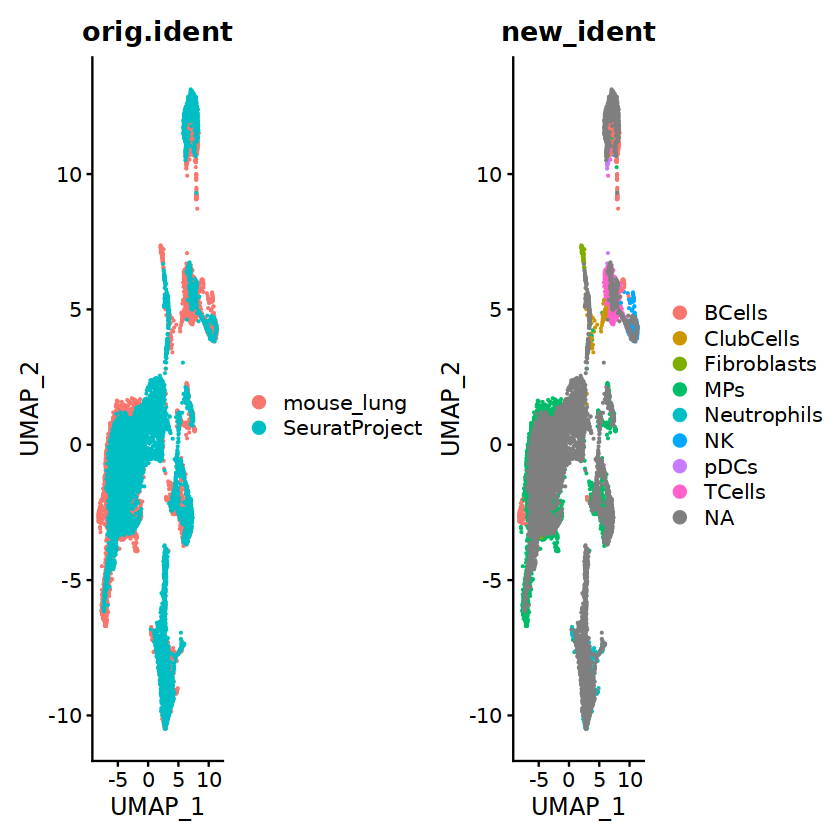

In [154]:
DimPlot(coembed, group.by = c("orig.ident", "new_ident"))

In [155]:
plot = DimPlot(coembed, group.by = c("orig.ident", "new_ident"))

In [156]:
ggsave(filename = "/SGRNJ06/randd/USER/cjj/celedev/atac/20240119scrna_atac/combined.jpg", height = 7, width = 12, plot = plot,
    quality = 50)

In [ ]:
table(coembed@meta.data$orig.ident)

In [ ]:
colnames(pbmc.atac@meta.data)

In [ ]:
UMAPPlot(pbmc.rna, group.by='celltype')

In [ ]:
FeaturePlot(pbmc.rna, features = "Cxcr2")

In [ ]:
DimPlot(pbmc.atac, label.size=5 ,group.by = "predicted.id", label = TRUE)

In [ ]:
FeaturePlot(pbmc.atac, features = "Mmp9")

In [ ]:
# Featureplot
# Csf3r,Mpo, Elane, Azu1
# Lyz2,Csf3r,Cxcr2或Lyz2,Camp,Lcn2
FeaturePlot(pbmc.atac, features = "Mpo")

In [ ]:
pbmc.atac@assays$ACTIVITY@counts

In [ ]:
pbmc.atac[['ACTIVITY']]@counts

In [ ]:
saveRDS(pbmc.atac, "/SGRNJ06/randd/USER/cjj/celedev/atac/20231204scrna_atac/atac.rds")